In [1]:
""" Data Preparation Script for Image Classification Task """

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt


# Set random seeds for to ensure reproducibility and consistensy when calibrating
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Define image size
px = 128

# Calculate mean and std for normalization

transform_mean_std = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root='archive/Training', transform=transform_mean_std)
loader = DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False)

mean = torch.zeros(1)
std = torch.zeros(1)
pixels = 0

for images, _ in loader:
    pixels += (images.size(0) * images.size(2) * images.size(3))
    mean += images.sum([0, 2, 3])

mean /= pixels
for images, _ in loader:
    std += ((images - mean[None, :, None, None]) ** 2).sum([0, 2, 3])

std = torch.sqrt(std / pixels)

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

# Define data augmentations and transformations for training and validation sets

transform_train = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

transform_val = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])  


train_dataset = datasets.ImageFolder(root='archive/Training', transform=transform_train)
val_dataset = datasets.ImageFolder(root='archive/Training', transform=transform_val)

# Split datasets into training and validation sets, using 80% for training and 20% for validation


train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

seed_for_split = 0  #to ensure the same split for train and val datasets, can be changed to verify calibration by checking validation accuracy for different seeds once parameters are set

generator = torch.Generator().manual_seed(seed_for_split)

train_dataset, _ = random_split(train_dataset, [train_size, val_size], generator=generator)

generator = torch.Generator().manual_seed(seed_for_split)

_, val_dataset = random_split(val_dataset, [train_size, val_size], generator=generator)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_loader))

print(f'Image batch dimensions: {images.shape}')
print(f'Image label dimensions: {labels.shape}')
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

class_names = train_loader.dataset.dataset.classes 
print(class_names) 
print(labels[0].item(), "->", class_names[labels[0]])


Calculated mean: tensor([0.1855])
Calculated std: tensor([0.1957])
Image batch dimensions: torch.Size([32, 1, 128, 128])
Image label dimensions: torch.Size([32])
Training dataset size: 4569
Validation dataset size: 1143
['glioma', 'meningioma', 'notumor', 'pituitary']
1 -> meningioma


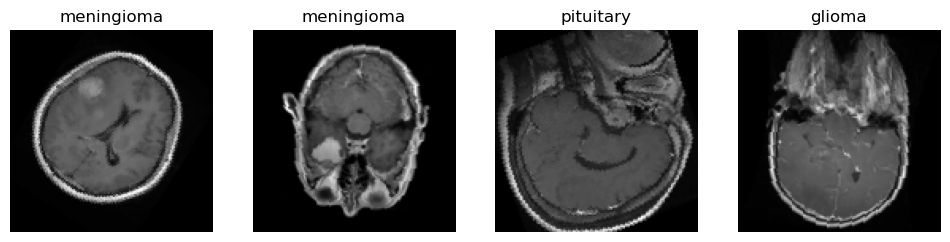

In [2]:
"""Function to display a sample of images from the input dataset"""

def imshow(img, ax, mean=mean, std=std):
    img = img.clone().cpu()
    img = img * std[:, None, None] + mean[:, None, None]  # Unnormalize
    img = img.numpy().transpose((1, 2, 0))  # C,H,W -> H,W,C
    img = np.clip(img, 0, 1)
    ax.imshow(img, cmap='gray')
    ax.axis("off")

# Display a sample of images from the training dataset

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    imshow(images[i], axs[i])
    axs[i].set_title(class_names[labels[i]])
plt.show()

Using device: mps
[Epoch 1] Average loss: 0.914
[Epoch 2] Average loss: 0.634
[Epoch 3] Average loss: 0.540
[Epoch 4] Average loss: 0.479
[Epoch 5] Average loss: 0.400
[Epoch 6] Average loss: 0.334
[Epoch 7] Average loss: 0.277
[Epoch 8] Average loss: 0.253
[Epoch 9] Average loss: 0.215
[Epoch 10] Average loss: 0.228
[Epoch 11] Average loss: 0.186
[Epoch 12] Average loss: 0.171
[Epoch 13] Average loss: 0.179
[Epoch 14] Average loss: 0.146
[Epoch 15] Average loss: 0.126
[Epoch 16] Average loss: 0.123
[Epoch 17] Average loss: 0.117
[Epoch 18] Average loss: 0.119
[Epoch 19] Average loss: 0.119
[Epoch 20] Average loss: 0.124
[Epoch 21] Average loss: 0.102
[Epoch 22] Average loss: 0.097
[Epoch 23] Average loss: 0.105
[Epoch 24] Average loss: 0.085
[Epoch 25] Average loss: 0.090
[Epoch 26] Average loss: 0.087
[Epoch 27] Average loss: 0.098
[Epoch 28] Average loss: 0.069
[Epoch 29] Average loss: 0.067
[Epoch 30] Average loss: 0.071
[Epoch 31] Average loss: 0.087
[Epoch 32] Average loss: 0.075

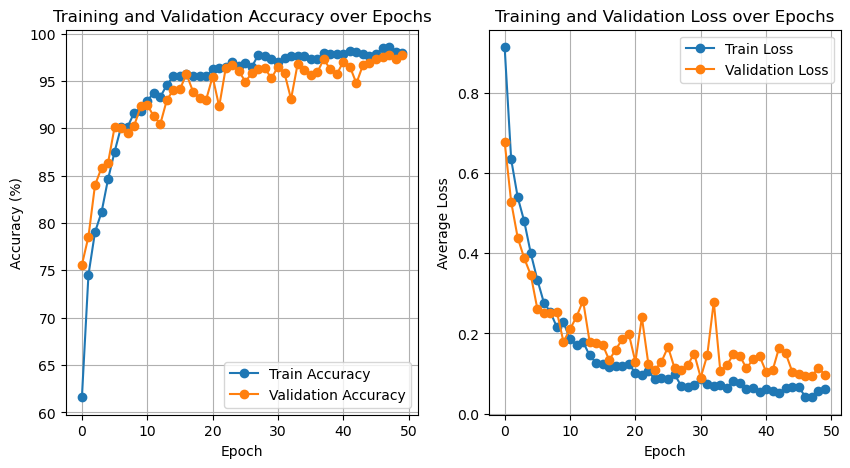

Final Training Accuracy: 97.90%
Final Validation Accuracy: 97.73%
Correctly Classified Training Samples: 4473.0/4569
Correctly Classified Validation Samples: 1117.0/1143


In [3]:
""" Convolutional Neural Network Training Script & Visualization of Training Loss"""

import torch.nn as nn
import torch.nn.functional as F

# Define the CNN architecture
initial_layer_size = 16
# Define image size, done before but kept here for clarity
px = 128

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, initial_layer_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(initial_layer_size, initial_layer_size*2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(initial_layer_size*2, initial_layer_size*4, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(initial_layer_size*4, initial_layer_size*8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(initial_layer_size*8 * (px // 16) * (px // 16), 512)
        self.fc2 = nn.Linear(512, 4)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, initial_layer_size*8 * (px // 16) * (px // 16))
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# Training the CNN using M chip if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

epoch_train_losses = []
epoch_val_losses = []
epoch_train_accuracies = []
epoch_val_accuracies = []
num_epochs = 50

running_loss = 0.0
running_accuracy = 0.0

for epoch in range(num_epochs):
    net.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * len(labels)
        running_accuracy += (outputs.argmax(1) == labels).sum().item()
    avg_loss = running_loss / len(train_dataset)
    print(f'[Epoch {epoch + 1}] Average loss: {avg_loss:.3f}')
    epoch_train_losses.append(avg_loss)
    epoch_train_accuracies.append(100 * running_accuracy / len(train_dataset))
    running_loss = 0.0
    running_accuracy = 0.0
    net.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * len(labels)
        running_accuracy += (outputs.argmax(1) == labels).sum().item()
    avg_val_loss = running_loss / len(val_dataset)
    epoch_val_losses.append(avg_val_loss)
    epoch_val_accuracies.append(100 * running_accuracy / len(val_dataset))
    running_loss = 0.0
    running_accuracy = 0.0
print('Finished Training')


# Plot training and validation accuracy and loss over epochs

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epoch_val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(epoch_train_losses, label='Train Loss', marker='o')
plt.plot(epoch_val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

print('Final Training Accuracy: {:.2f}%'.format(epoch_train_accuracies[-1]))
print('Final Validation Accuracy: {:.2f}%'.format(epoch_val_accuracies[-1]))
print('Correctly Classified Training Samples: {}/{}'.format(epoch_train_accuracies[-1]* len(train_dataset) / 100, len(train_dataset)))
print('Correctly Classified Validation Samples: {}/{}'.format(epoch_val_accuracies[-1] * len(val_dataset) / 100, len(val_dataset)))


Random validation samples:


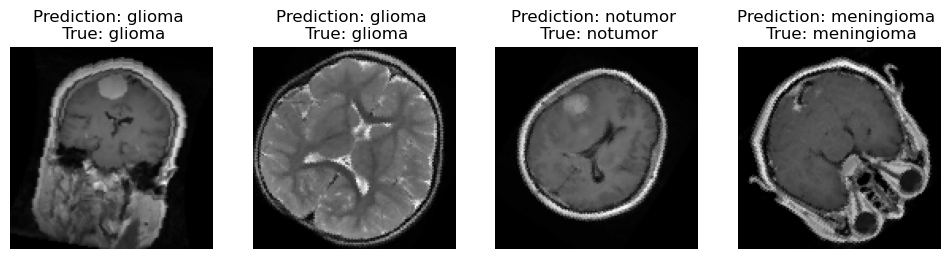

In [4]:
""" Visualizing some predictions on the validation set """
print('Random validation samples:')
_, predicted = torch.max(outputs, 1)
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
random_indices = np.random.choice(range(labels.size(0)), size=4, replace=False)
for i in range(4):
    imshow(images[random_indices[i]], axs[i])
    axs[i].set_title(f'Prediction: {class_names[predicted[random_indices[i]]]} \n True: {class_names[labels[random_indices[i]]]}')


In [5]:
""" SVM Classifier with HOG Features and Data Augmentation """

from sklearn.svm import SVC
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from PIL import Image, ImageOps
from sklearn.metrics import classification_report, accuracy_score
from skimage import color
from sklearn.metrics import hinge_loss



def augment_variants(img):
    pil = Image.fromarray(img)
    return [
        np.array(pil),
        np.array(ImageOps.mirror(pil)),
        np.array(ImageOps.flip(pil)),
        np.array(pil.rotate(np.random.randint(0,360))),
        ]


def extract_features(dataset, augment=True):
    images = []
    features = []
    labels = []
    for img, label in dataset:
        if augment:
            variations = augment_variants(img.squeeze().numpy())
            for var in variations:
                images.append(img)  
                features.append(hog(var, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)))
                labels.append(label)
        else:
            images.append(img)  
            features.append(hog(img.squeeze().numpy(), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)))
            labels.append(label)
    return images, np.array(features), np.array(labels)

Train_images, Train_X, Train_Y = extract_features(dataset, augment=True)
print('Feature extraction completed.')
print(f'Train_X shape: {Train_X.shape}, Train_Y shape: {Train_Y.shape}')

# Hyperparameter tuning for SVM using GridSearchCV with StratifiedKFold cross-validation

base_clf = make_pipeline(
    StandardScaler(),
    SVC(decision_function_shape='ovr', kernel='rbf', gamma='scale')
)
param_grid = {
    'svc__C': [3.5, 4, 4.5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(base_clf, param_grid, cv=cv, n_jobs=4, refit=True, verbose=3)
grid.fit(Train_X, Train_Y)
print(f'Best SVM C value: {grid.best_params_["svc__C"]}, Best mean cross validation accuracy: {grid.best_score_ * 100:.2f}%')

clf = grid.best_estimator_
decision_values = clf.decision_function(Train_X)
hinge_loss_value = hinge_loss(Train_Y, decision_values)
print(f'Accuracy on Training Set: {accuracy_score(Train_Y, clf.predict(Train_X)) * 100:.2f}%')
print(f'Hinge loss for SVM Classifier Report on Training Set: {hinge_loss_value:.2f}')


Feature extraction completed.
Train_X shape: (22848, 8100), Train_Y shape: (22848,)
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 4/5] END ........................svc__C=3.5;, score=0.928 total time=29.1min
[CV 1/5] END ........................svc__C=3.5;, score=0.936 total time=29.3min
[CV 3/5] END ........................svc__C=3.5;, score=0.931 total time=29.4min
[CV 2/5] END ........................svc__C=3.5;, score=0.938 total time=29.4min
[CV 1/5] END ..........................svc__C=4;, score=0.936 total time=28.9min
[CV 3/5] END ..........................svc__C=4;, score=0.931 total time=28.8min
[CV 2/5] END ..........................svc__C=4;, score=0.938 total time=29.0min
[CV 5/5] END ........................svc__C=3.5;, score=0.933 total time=30.2min
[CV 4/5] END ..........................svc__C=4;, score=0.928 total time=27.7min
[CV 5/5] END ..........................svc__C=4;, score=0.933 total time=27.8min
[CV 1/5] END ........................svc__C=4.

CNN
Number of test samples: 1311
Average Test loss: 0.00
Test accuracy: 97.64%
Correct predictions CNN: 1280/1311
Incorrect predictions/mistakes CNN: 31/1311
Expected Calibration Error (ECE): 0.0436
              precision    recall  f1-score   support

      glioma       0.99      0.95      0.97       300
  meningioma       0.95      0.96      0.95       306
     notumor       0.99      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Confusion Matrix:


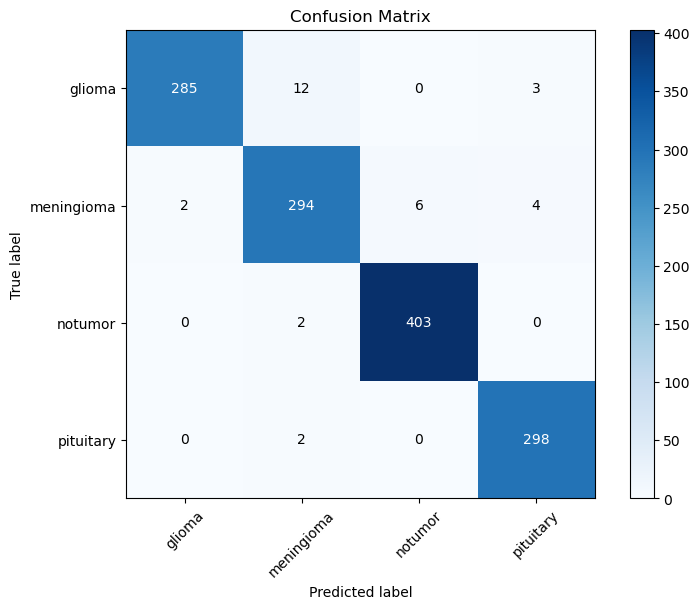

SVM
Number of test samples: 1311
Test accuracy: 97.64‰
Correct predictions SVM: 1280/1311
Incorrect predictions SVM: 31/1311
Expected Calibration Error (ECE) with 10 bins: 2.1706
              precision    recall  f1-score   support

      glioma       1.00      0.92      0.96       300
  meningioma       0.92      0.99      0.95       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311

Confusion Matrix:


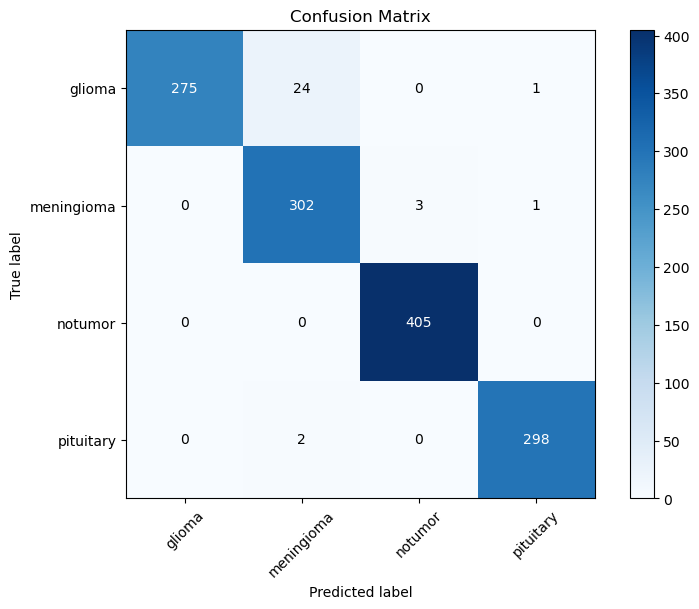

In [ ]:
""" Model Evaluation on Test Set for both CNN and SVM , only runs once when both models are calibrated and trained """
from sklearn.metrics import classification_report, accuracy_score

# Loading dataset using the validation transformations

dataset = datasets.ImageFolder(root='archive/Testing', transform=transform_val)
loader = DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False)

# Function to compute Expected Calibration Error (ECE)
def ece_score(probs, labels):
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bin_edges[i]
        bin_upper = bin_edges[i + 1]
        if i != n_bins - 1:
            in_bin_idx = np.where((probs >= bin_lower) & (probs < bin_upper))[0]
        else:
            in_bin_idx = np.where((probs >= bin_lower) & (probs <= bin_upper))[0]
        prop_in_bin = len(in_bin_idx) / len(probs)
        if prop_in_bin > 0:
            accuracy_in_bin = (labels[in_bin_idx] == probs[in_bin_idx].argmax(axis=1)).sum() / len(in_bin_idx)
            avg_confidence_in_bin = probs[in_bin_idx].max(axis=1).sum() / len(in_bin_idx)
            ece += np.abs(accuracy_in_bin - avg_confidence_in_bin) * prop_in_bin
    return ece

all_labels = []
all_preds = []
all_probs = []
total_loss = 0.0
net.eval()

with torch.no_grad():
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        total_loss += criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(outputs.softmax(dim=1).cpu().numpy())

total = len(dataset)
loss = total_loss / total


all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)
correct = np.sum(all_preds == all_labels)

print('CNN')
print(f'Number of test samples: {len(dataset)}')
print(f'Average Test loss: {loss:.2f}')
print(f'Test accuracy: {(100 * np.sum(all_preds == all_labels) / total):.2f}%')
print(f'Correct predictions CNN: {np.sum(all_preds == all_labels)}/{total}')
print(f'Incorrect predictions/mistakes CNN: {total-np.sum(all_preds == all_labels)}/{total}')
print(f'Expected Calibration Error (ECE): {ece_score(np.array(all_probs), np.array(all_labels)):.4f}')
print(classification_report(all_labels, all_preds, target_names=class_names))

confusion_matrix = np.zeros((len(class_names), len(class_names)), dtype=int)
for true_label, pred_label in zip(all_labels, all_preds):
    confusion_matrix[true_label, pred_label] += 1

thresh = confusion_matrix.max() / 2.

print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(
            j, i, f"{confusion_matrix[i, j]}",
            ha="center", va="center",
            color="white" if confusion_matrix[i, j] > thresh else "black"
        )
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


test_img, test_X, test_Y = extract_features(dataset, augment=False)

preds = clf.predict(test_X)
print('SVM')
print(f'Number of test samples: {len(test_X)}')
print(f'Test accuracy: {(100 * np.sum(preds == test_Y) / len(test_Y)):.2f}‰')
print(f'Correct predictions SVM: {np.sum(preds == test_Y)}/{len(test_Y)}')
print(f'Incorrect predictions SVM: {np.sum(preds != test_Y)}/{len(test_Y)}')
print(classification_report(test_Y, preds, target_names=class_names))

confusion_matrix = np.zeros((len(class_names), len(class_names)), dtype=int)
for true_label, pred_label in zip(test_Y, preds):
    confusion_matrix[true_label, pred_label] += 1

print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(
            j, i, f"{confusion_matrix[i, j]}",
            ha="center", va="center",
            color="white" if confusion_matrix[i, j] > thresh else "black"
        )
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

